In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [2]:
import pandas as pd

data = pd.read_csv("processed_financial_data.xls")

data.head()


,label,sentence,processed_text,sentiment_score,predicted_label
0,neutral,"According to Gran , the company has no plans t...",according gran company plan move production ru...,0.059300,positive
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less 100 0...,-0.055556,negative
2,negative,The international electronic industry company ...,international electronic industry company elco...,-0.053333,negative
3,positive,With the new production plant the company woul...,new production plant company would increase ca...,0.595251,positive
4,positive,According to the company 's updated strategy f...,according company updated strategy year 2009 2...,0.539287,positive


In [3]:
class FeatureExtractor:
    def __init__(self, max_features=5000, ngram_range=(1, 2)):
        self.max_features = max_features
        self.ngram_range = ngram_range
        
        self.bow_vectorizer = CountVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            min_df=2,
            max_df=0.8,
            stop_words='english'
        )
        
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            min_df=2,
            max_df=0.8,
            stop_words='english'
        )
    
    def fit_transform_bow(self, texts):
        """
        Create Bag-of-Words feature matrix.
        Returns: (sparse matrix, feature names)
        """
        X_bow = self.bow_vectorizer.fit_transform(texts)
        feature_names = self.bow_vectorizer.get_feature_names_out()
        return X_bow, feature_names
    
    def fit_transform_tfidf(self, texts):
        """
        Create TF-IDF feature matrix.
        Returns: (sparse matrix, feature names)
        """
        X_tfidf = self.tfidf_vectorizer.fit_transform(texts)
        feature_names = self.tfidf_vectorizer.get_feature_names_out()
        return X_tfidf, feature_names
    
    def get_top_features(self, vectorizer, X, n=20):
        """
        Get top n most important features by TF-IDF score.
        Returns: [(feature_name, score), ...]
        """
        avg_scores = X.mean(axis=0).A1  # average score per feature
        feature_names = vectorizer.get_feature_names_out()
        
        top_indices = avg_scores.argsort()[::-1][:n]
        return [(feature_names[i], avg_scores[i]) for i in top_indices]
    
    def visualize_top_features(self, vectorizer, X, n=20):
        """
        Plot top features as horizontal bar chart.
        Returns: matplotlib figure
        """
        top_features = self.get_top_features(vectorizer, X, n)
        words, scores = zip(*top_features)
        
        plt.figure(figsize=(8, 6))
        plt.barh(words[::-1], scores[::-1])
        plt.xlabel("Average TF-IDF Score")
        plt.title("Top TF-IDF Features")
        plt.tight_layout()
        plt.show()
        
        return plt


In [4]:
# Create feature extractor
fe = FeatureExtractor()

# Get text data (use processed_text or sentence)
texts = data["processed_text"].astype(str).tolist()

# Generate features
X_bow, bow_features = fe.fit_transform_bow(texts)
X_tfidf, tfidf_features = fe.fit_transform_tfidf(texts)


In [5]:


print("FEATURE EXTRACTION RESULTS")
print("═" * 55)

print(f"\nBoW Shape: {X_bow.shape}")
print(f"TF-IDF Shape: {X_tfidf.shape}")
print(f"Vocabulary Size: {len(tfidf_features)}")

print("\nTop 10 Most Informative Features (by average TF-IDF):")

top_features = fe.get_top_features(
    fe.tfidf_vectorizer,
    X_tfidf,
    n=10
)

for i, (word, score) in enumerate(top_features, 1):
    print(f"{i}. {word:<15} (avg_tfidf: {score:.2f})")

#  SAMPLE SENTENCE ANALYSIS 

sample_text = ["strong profit growth"]

# Transform (NOT fit again)
sample_bow = fe.bow_vectorizer.transform(sample_text)
sample_tfidf = fe.tfidf_vectorizer.transform(sample_text)

# BoW features
bow_feature_names = fe.bow_vectorizer.get_feature_names_out()
bow_indices = sample_bow.nonzero()[1]

bow_output = [
    f"{bow_feature_names[i]}=1"
    for i in bow_indices
]

# TF-IDF features
tfidf_feature_names = fe.tfidf_vectorizer.get_feature_names_out()
tfidf_indices = sample_tfidf.nonzero()[1]

tfidf_output = [
    f"{tfidf_feature_names[i]}={sample_tfidf[0, i]:.2f}"
    for i in tfidf_indices
]

print('\nSample: "strong profit growth"')
print("  BoW features:", bow_output)
print("  TF-IDF features:", tfidf_output)


FEATURE EXTRACTION RESULTS
═══════════════════════════════════════════════════════

BoW Shape: (4846, 5000)
TF-IDF Shape: (4846, 5000)
Vocabulary Size: 5000

Top 10 Most Informative Features (by average TF-IDF):
1. eur             (avg_tfidf: 0.03)
2. company         (avg_tfidf: 0.02)
3. mn              (avg_tfidf: 0.02)
4. sale            (avg_tfidf: 0.02)
5. said            (avg_tfidf: 0.01)
6. year            (avg_tfidf: 0.01)
7. million         (avg_tfidf: 0.01)
8. share           (avg_tfidf: 0.01)
9. finnish         (avg_tfidf: 0.01)
10. net             (avg_tfidf: 0.01)

Sample: "strong profit growth"
  BoW features: ['growth=1', 'profit=1', 'strong=1']
  TF-IDF features: ['growth=0.60', 'profit=0.39', 'strong=0.69']


In [6]:

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)


# MODEL TRAINER CLASS 
class ModelTrainer:
    def __init__(self):
        self.models = {}
        self.results = {}
        self.best_model = None
    
    def train_logistic_regression(self, X_train, y_train, X_val, y_val):
        """
        Train Logistic Regression with hyperparameter tuning.
        """
        param_grid = {'C': [0.1, 1.0, 10.0]}
        lr = LogisticRegression(max_iter=1000, random_state=42)

        grid_search = GridSearchCV(
            lr,
            param_grid,
            cv=5,
            scoring='f1_weighted'
        )
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val)
        
        metrics = self._calculate_metrics(y_val, y_pred)

        self.models['Logistic Regression'] = best_model
        self.results['Logistic Regression'] = metrics
        
        return best_model, metrics
    
    def train_naive_bayes(self, X_train, y_train, X_val, y_val):
        """
        Train Naive Bayes (no hyperparameter tuning needed).
        """
        nb = MultinomialNB()
        nb.fit(X_train, y_train)
        y_pred = nb.predict(X_val)
        
        metrics = self._calculate_metrics(y_val, y_pred)

        self.models['Naive Bayes'] = nb
        self.results['Naive Bayes'] = metrics
        
        return nb, metrics
    
    def train_knn(self, X_train, y_train, X_val, y_val):
        """
        Train K-Nearest Neighbors with hyperparameter tuning.
        """
        param_grid = {'n_neighbors': [3, 5, 7]}
        knn = KNeighborsClassifier(metric='cosine')

        grid_search = GridSearchCV(
            knn,
            param_grid,
            cv=5,
            scoring='f1_weighted'
        )
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val)
        
        metrics = self._calculate_metrics(y_val, y_pred)

        self.models['KNN'] = best_model
        self.results['KNN'] = metrics
        
        return best_model, metrics
    
    def _calculate_metrics(self, y_true, y_pred):
        """Calculate all evaluation metrics."""
        return {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
            'confusion_matrix': confusion_matrix(y_true, y_pred)
        }
    
    def compare_models(self):
        """Create comparison table."""
        return pd.DataFrame(self.results).T


In [7]:
from sklearn.model_selection import train_test_split

X = X_tfidf
y = data["label"]    


X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (3392, 5000)
Validation shape: (727, 5000)
Test shape: (727, 5000)


In [8]:
trainer = ModelTrainer()

lr_model, lr_metrics = trainer.train_logistic_regression(X_train, y_train, X_val, y_val)
nb_model, nb_metrics = trainer.train_naive_bayes(X_train, y_train, X_val, y_val)
knn_model, knn_metrics = trainer.train_knn(X_train, y_train, X_val, y_val)

trainer.compare_models()


,accuracy,precision,recall,f1,confusion_matrix
Logistic Regression,0.734525,0.724756,0.734525,0.724658,"[[40, 34, 16], [14, 378, 40], [11, 78, 116]]"
Naive Bayes,0.709766,0.719044,0.709766,0.668529,"[[15, 52, 23], [2, 412, 18], [1, 115, 89]]"
KNN,0.679505,0.661772,0.679505,0.659298,"[[37, 34, 19], [20, 379, 33], [20, 107, 78]]"


In [9]:
# Use model from Task 2 (trained on 70% data)
# Evaluate on 15% test set (NEVER USED FOR TRAINING)
best_model=lr_model
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision_per_class = precision_score(y_test, y_pred, average=None)
recall_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)
cm = confusion_matrix(y_test, y_pred)

In [10]:
# 5-fold CV on training set to check model stability
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1_weighted')
print(f"CV Scores: {scores}")
print(f"Mean: {scores.mean():.3f} ± {scores.std():.3f}")
# Good if std is small (<0.05), meaning stable across folds

CV Scores: [0.70677804 0.72564901 0.74463114 0.71376781 0.75330042]
Mean: 0.729 ± 0.018


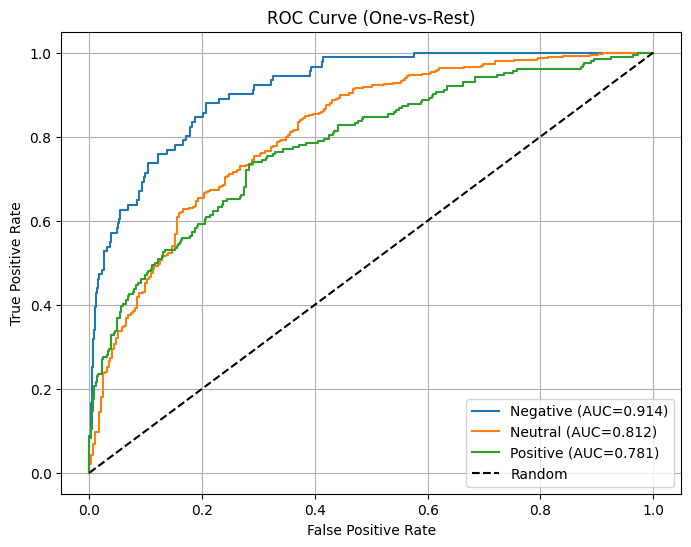

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

class_names = ['negative', 'neutral', 'positive']

for label in class_names:
    class_id = label_to_id[label]
    
    y_true_binary = (y_test == label).astype(int)
    y_pred_proba = best_model.predict_proba(X_test)[:, class_id]

    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_proba)
    roc_auc = roc_auc_score(y_true_binary, y_pred_proba)

    plt.plot(fpr, tpr, label=f'{label.capitalize()} (AUC={roc_auc:.3f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Precision-Recall Curve')

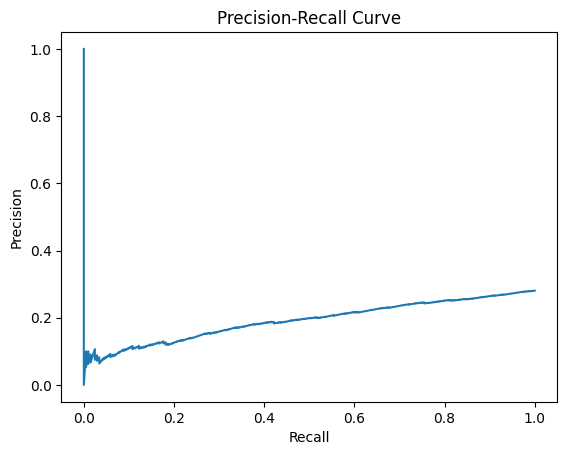

In [24]:

# For best class (usually positive or negative)
from sklearn.metrics import precision_recall_curve
positive_label = "positive"
y_true_binary = (y_test ==positive_label ).astype(int)  # Example: positive class
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_true_binary, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
# Shows tradeoff: can increase recall by lowering threshold, but precision drops